In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# --- Chapter 1: Understand the Training Data ---

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Load the datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
submission_df = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")


# --- Chapter 2: Feature Engineering: Creating BMI ---

In [3]:
# Convert Height from cm to meters for BMI calculation
train_df['Height_m'] = train_df['Height'] / 100
test_df['Height_m'] = test_df['Height'] / 100

# Calculate BMI
train_df['BMI'] = train_df['Weight'] / (train_df['Height_m'] ** 2)
test_df['BMI'] = test_df['Weight'] / (test_df['Height_m'] ** 2)

# Display the first few rows with the new 'BMI' column
print("\nTraining Data with new 'BMI' feature:")
print(train_df[['Height', 'Weight', 'Height_m', 'BMI', 'Calories']].head())

print("\nTest Data with new 'BMI' feature:")
print(test_df[['Height', 'Weight', 'Height_m', 'BMI']].head())

print("\nFeature Engineering (Before EDA) completed.")



Training Data with new 'BMI' feature:
   Height  Weight  Height_m        BMI  Calories
0   189.0    82.0      1.89  22.955684     150.0
1   163.0    60.0      1.63  22.582709      34.0
2   161.0    64.0      1.61  24.690405      29.0
3   192.0    90.0      1.92  24.414062     140.0
4   166.0    61.0      1.66  22.136740     146.0

Test Data with new 'BMI' feature:
   Height  Weight  Height_m        BMI
0   177.0    81.0      1.77  25.854639
1   200.0    97.0      2.00  24.250000
2   188.0    85.0      1.88  24.049344
3   172.0    73.0      1.72  24.675500
4   173.0    67.0      1.73  22.386314

Feature Engineering (Before EDA) completed.


# --- Chapter 3: Exploratory Data Analysis (EDA) ---

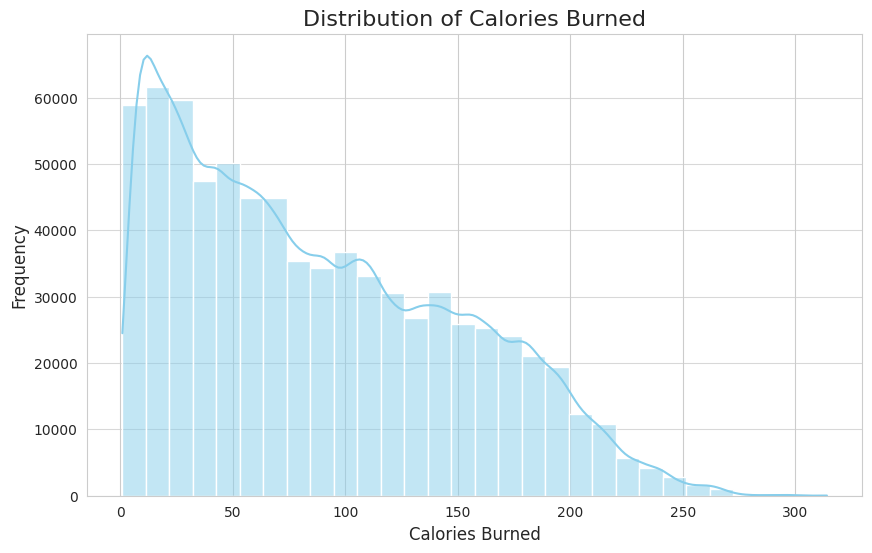

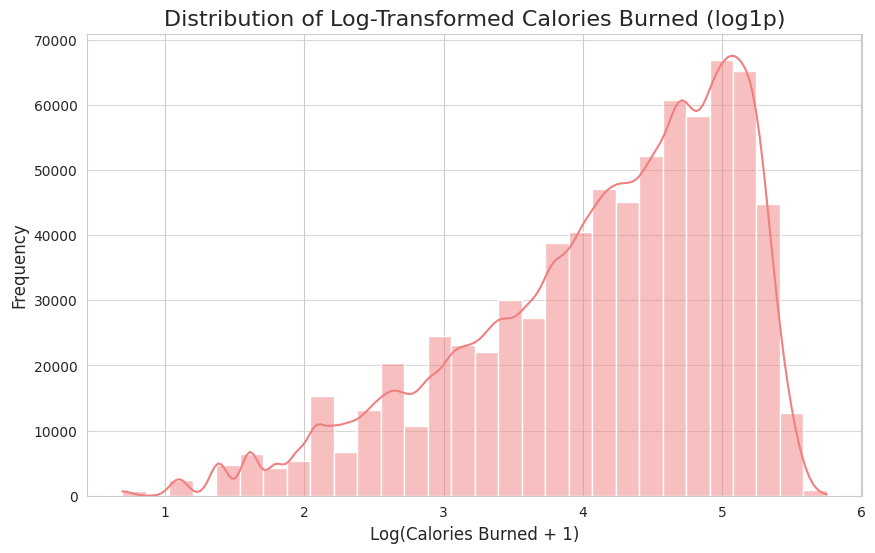

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set aesthetic style for plots
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Inter' # Set font to Inter

# 1. Distribution of Target Variable (Calories)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Calories'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Calories Burned', fontsize=16)
plt.xlabel('Calories Burned', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Since the evaluation metric is RMSLE, let's also visualize the log-transformed target
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['Calories']), kde=True, bins=30, color='lightcoral')
plt.title('Distribution of Log-Transformed Calories Burned (log1p)', fontsize=16)
plt.xlabel('Log(Calories Burned + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()


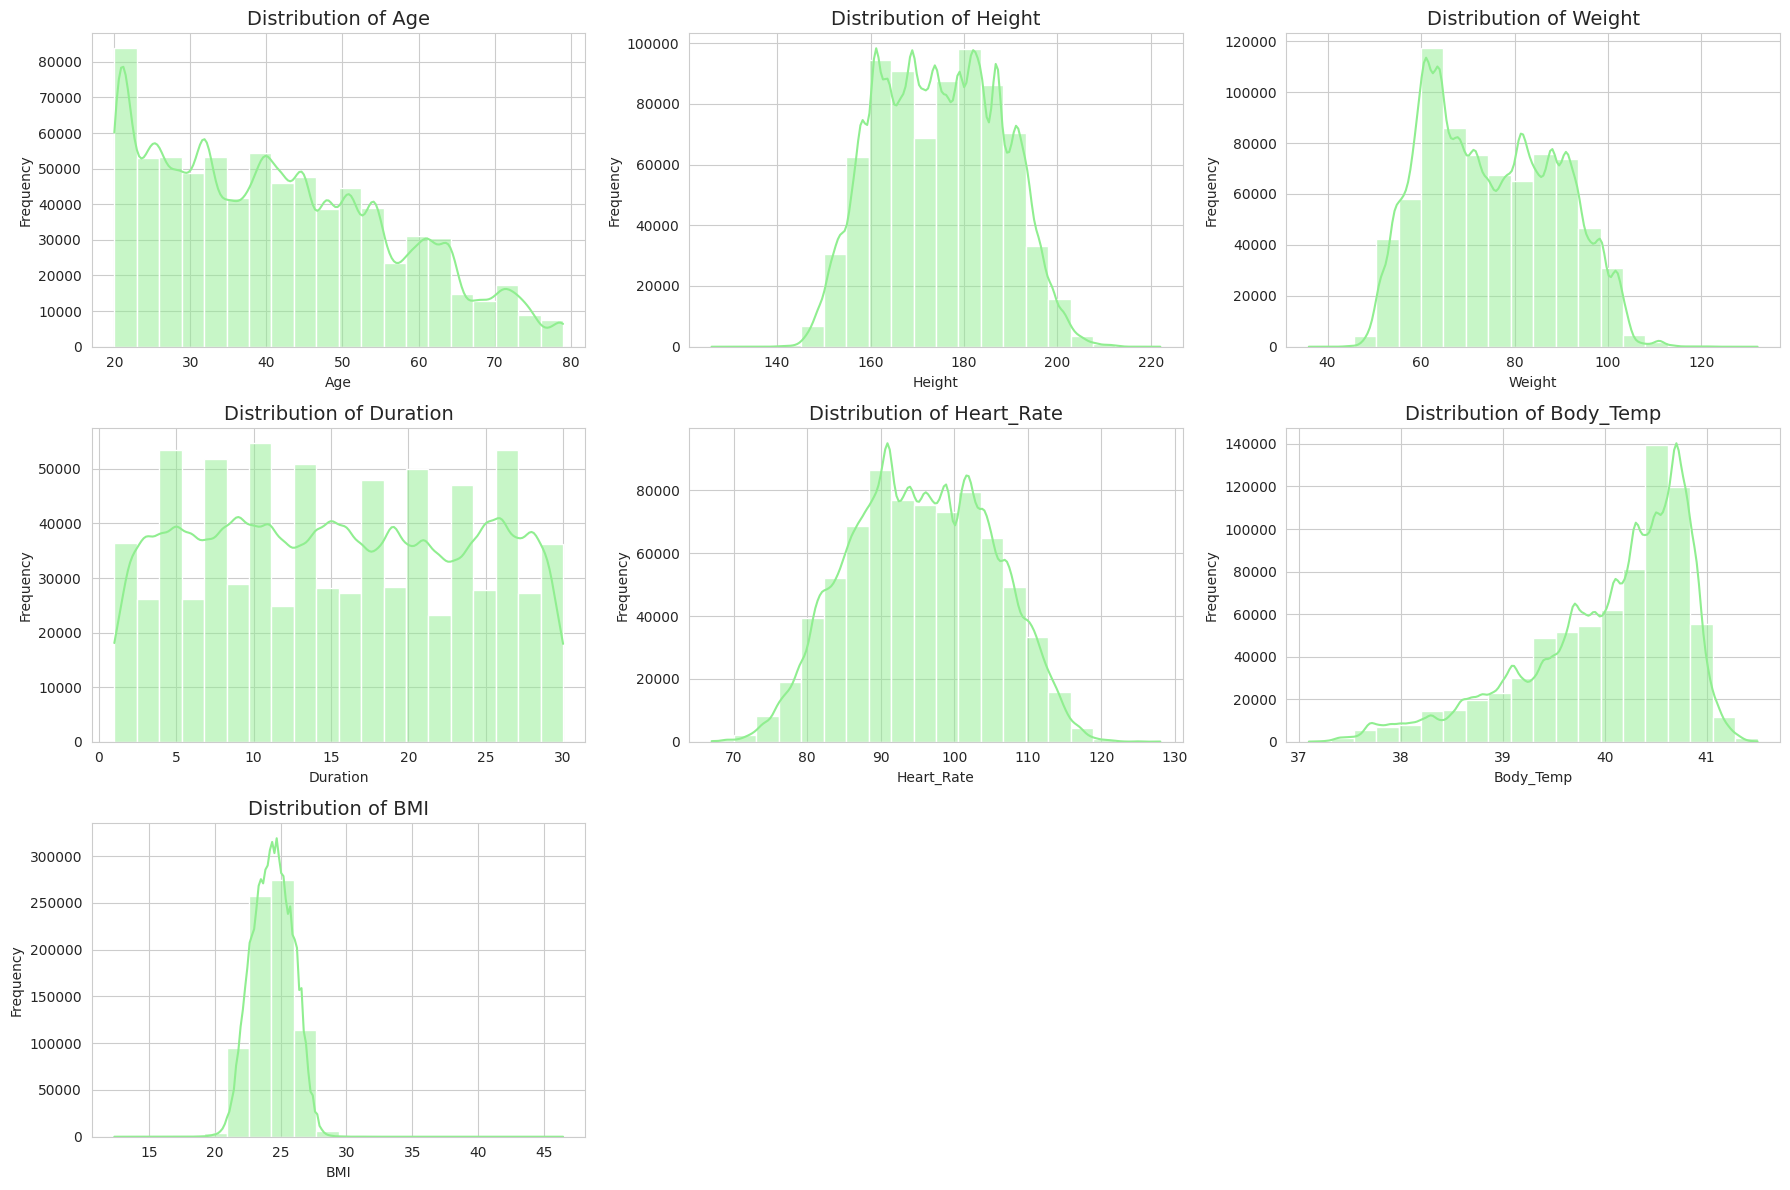

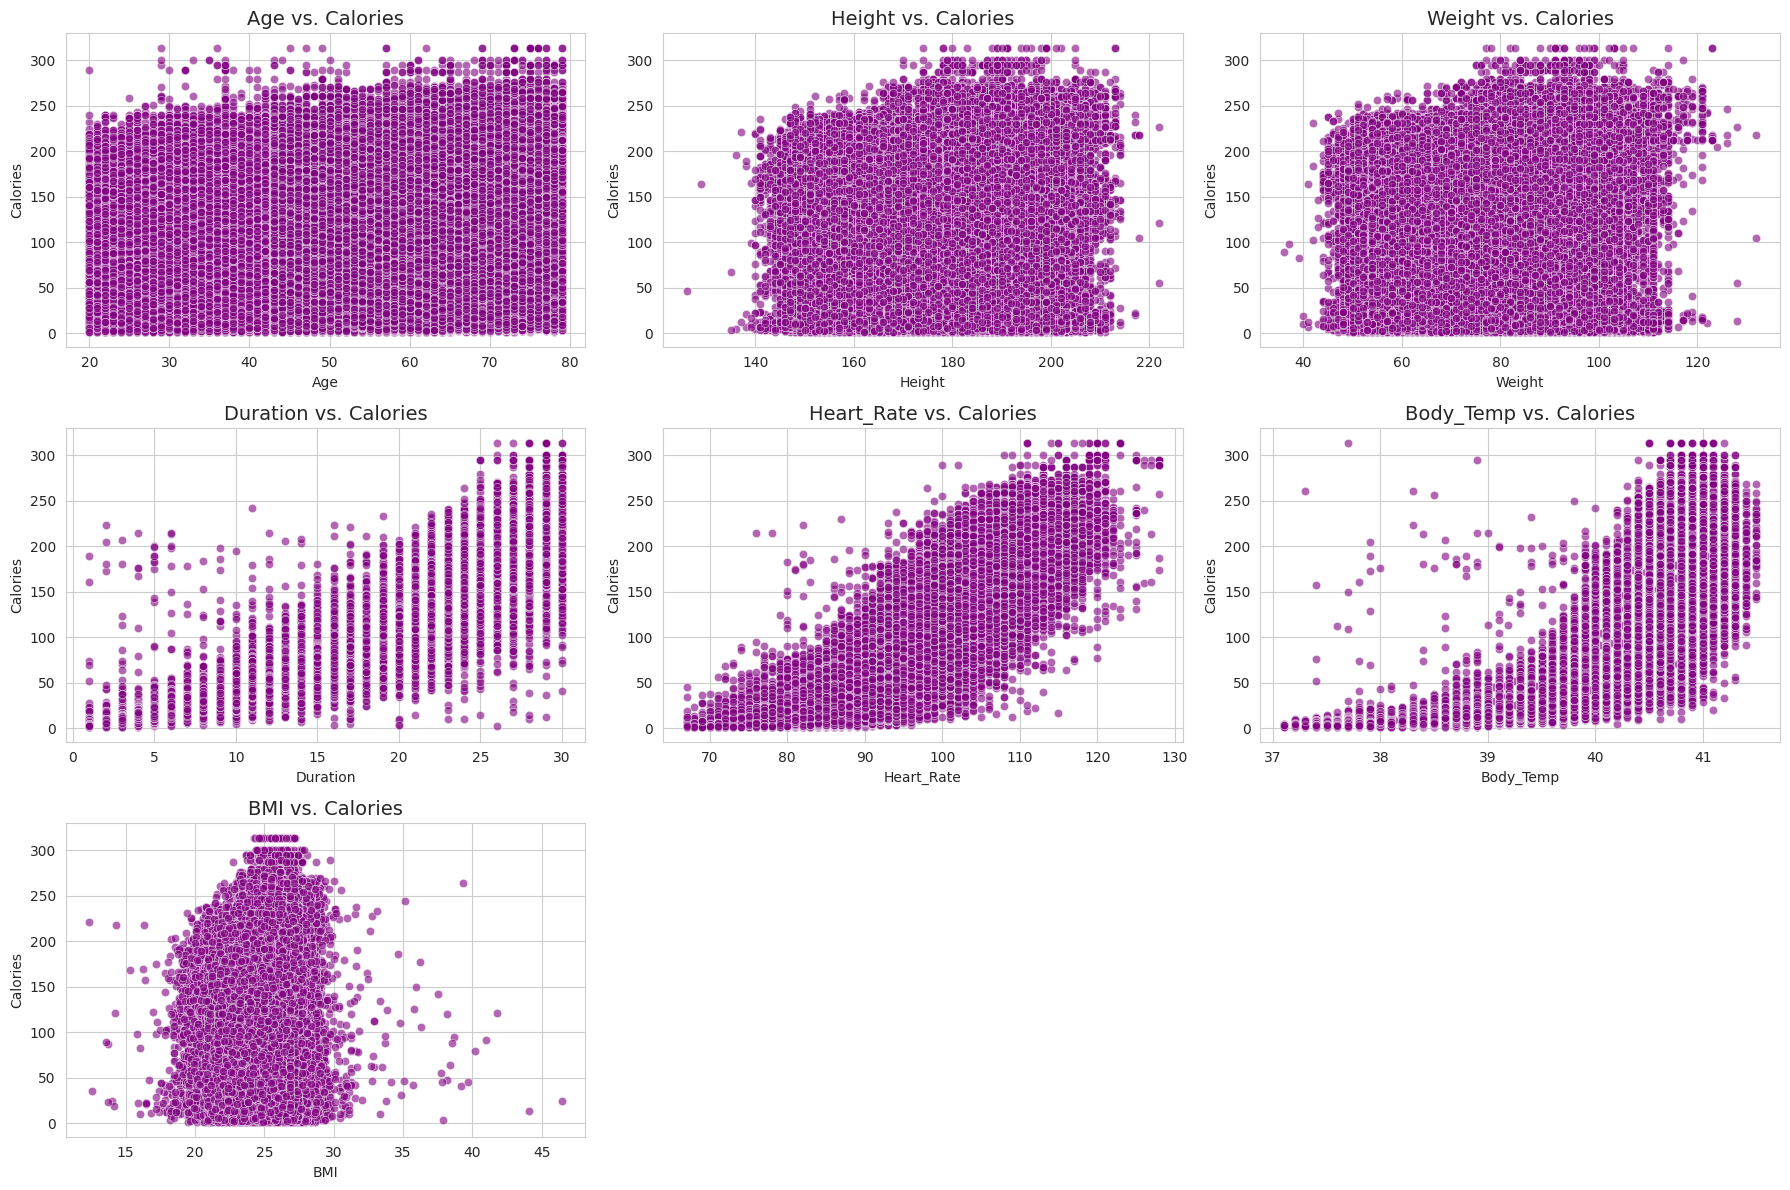

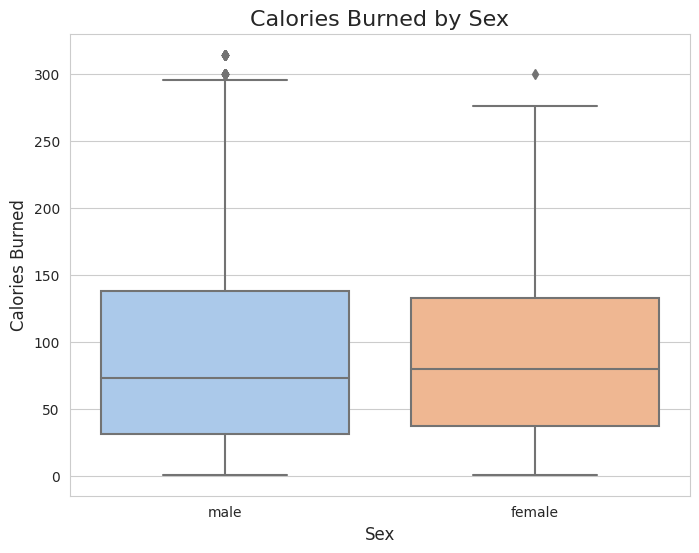

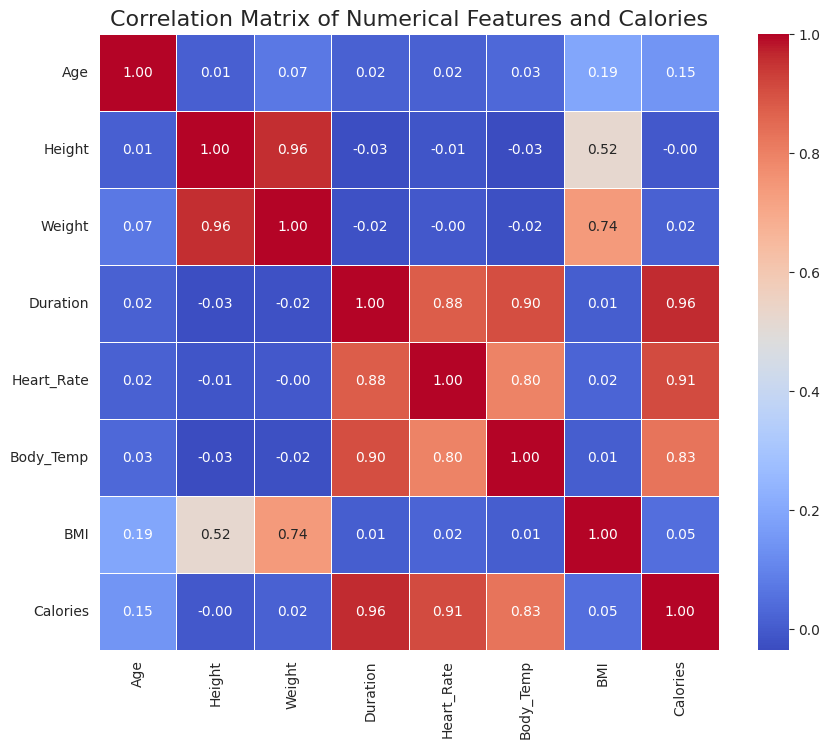


Exploratory Data Analysis (EDA) completed. Review the generated plots for insights.


In [5]:
# 2. Distributions of Numerical Features
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(train_df[feature], kde=True, bins=20, color='lightgreen')
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
plt.tight_layout()
plt.show()


# 3. Relationship between Numerical Features and Calories (Scatter Plots)
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=train_df[feature], y=train_df['Calories'], alpha=0.6, color='purple')
    plt.title(f'{feature} vs. Calories', fontsize=14)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Calories', fontsize=10)
plt.tight_layout()
plt.show()


# 4. Box Plot for Categorical Feature (Sex) vs. Calories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sex', y='Calories', data=train_df, palette='pastel')
plt.title('Calories Burned by Sex', fontsize=16)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Calories Burned', fontsize=12)
plt.show()


# 5. Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[numerical_features + ['Calories']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Calories', fontsize=16)
plt.show()

print("\nExploratory Data Analysis (EDA) completed. Review the generated plots for insights.")


# --- Chapter 4: Dimensionality Reduction (PCA) ---

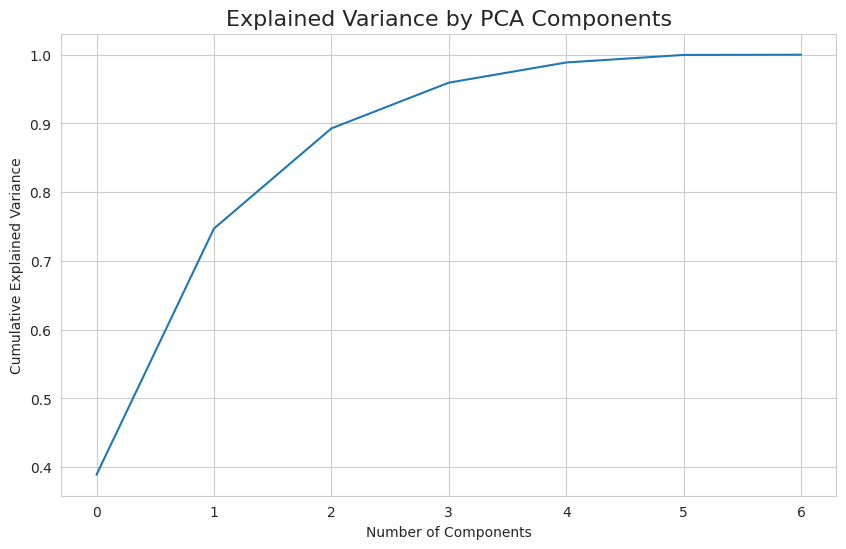

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Identify numerical features for PCA (excluding 'id' and 'Calories')
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data numerical features and transform both train and test
X_train_scaled = scaler.fit_transform(train_df[numerical_cols])
X_test_scaled = scaler.transform(test_df[numerical_cols])

# Convert scaled arrays back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=train_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=test_df.index)

# Initialize PCA
pca = PCA()
pca.fit(X_train_scaled_df)

# Plot explained variance ratio to help decide number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components', fontsize=16)
plt.grid(True)
plt.show()

# Based on the plot, decide on the number of components.
n_components_to_keep = 3 # Example: Keep 3 principal components

pca = PCA(n_components=n_components_to_keep)
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca = pca.transform(X_test_scaled_df)

pca_train_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components_to_keep)], index=train_df.index)
pca_test_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components_to_keep)], index=test_df.index)

train_df = pd.concat([train_df, pca_train_df], axis=1)
test_df = pd.concat([test_df, pca_test_df], axis=1)


# --- Chapter 5: Clustering (K-Means) ---

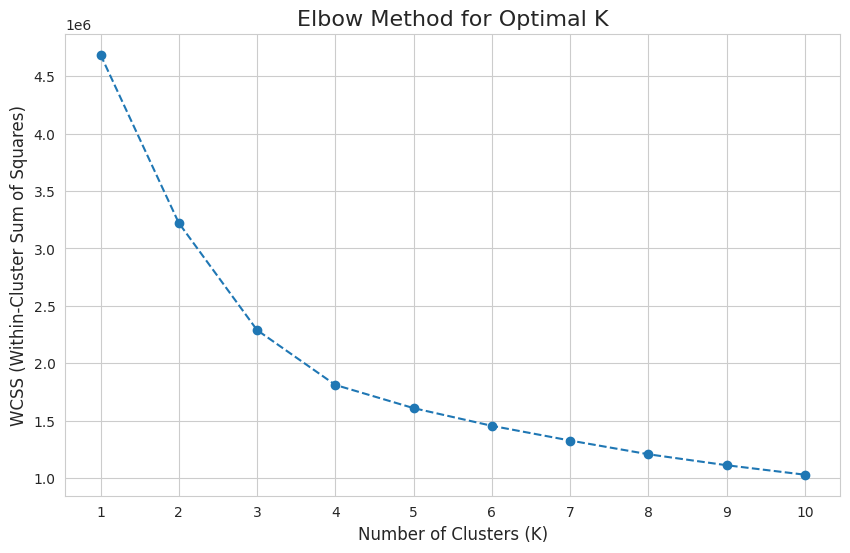


K-Means Clustering performed with K = 3.
Training Data with new 'Cluster' feature (first 5 rows):
        PC1       PC2       PC3  Cluster
0 -1.674336  0.643062 -0.813202        0
1  1.137453 -1.832870  1.584856        1
2  1.284241 -1.122501  0.988741        1
3 -1.492351  1.517795 -1.785272        0
4 -1.689873 -1.607583 -0.257044        2


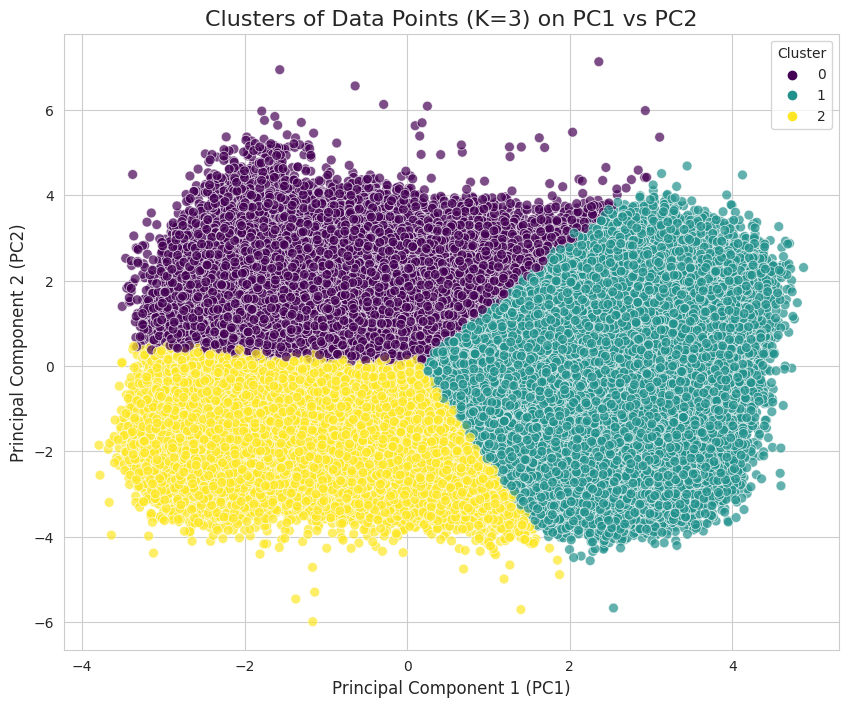


Clustering completed. The 'Cluster' feature has been added to both datasets.


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use PCA components for clustering
features_for_clustering_train = train_df[[f'PC{i+1}' for i in range(n_components_to_keep)]]
features_for_clustering_test = test_df[[f'PC{i+1}' for i in range(n_components_to_keep)]]

# 1. Elbow Method to find optimal number of clusters (K)
# We'll test K from 1 to 10
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(features_for_clustering_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Based on the elbow plot, choose an optimal K.
optimal_k = 3 

# 2. Apply K-Means Clustering with the optimal K
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)

# Fit KMeans on training data's PCA components
train_df['Cluster'] = kmeans.fit_predict(features_for_clustering_train)

# Predict clusters for test data using the fitted KMeans model
test_df['Cluster'] = kmeans.predict(features_for_clustering_test)

print(f"\nK-Means Clustering performed with K = {optimal_k}.")
print("Training Data with new 'Cluster' feature (first 5 rows):")
print(train_df[['PC1', 'PC2', 'PC3', 'Cluster']].head())

# 3. Visualize the clusters (using first two principal components)
if n_components_to_keep >= 2:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=train_df, palette='viridis', s=50, alpha=0.7)
    plt.title(f'Clusters of Data Points (K={optimal_k}) on PC1 vs PC2', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
else:
    print("\nCannot visualize clusters on PC1 vs PC2 as less than 2 principal components were kept.")

print("\nClustering completed. The 'Cluster' feature has been added to both datasets.")


# --- Chapter 6: Feature Engineering & Selection (After EDA) ---

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# 1. Create New Interaction Features
# A simple interaction term: Duration * Heart_Rate (proxy for total effort/work)
train_df['Duration_HeartRate_Product'] = train_df['Duration'] * train_df['Heart_Rate']
test_df['Duration_HeartRate_Product'] = test_df['Duration'] * test_df['Heart_Rate']

# Another potential interaction: Age * Duration
train_df['Age_Duration_Product'] = train_df['Age'] * train_df['Duration']
test_df['Age_Duration_Product'] = test_df['Age'] * test_df['Duration']

print("\nCreated new interaction features: 'Duration_HeartRate_Product' and 'Age_Duration_Product'.")


# 2. Identify Categorical and Numerical Features for Preprocessing
# Original numerical features + BMI + new interaction features
numerical_features_for_transformer = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI',
                                      'Duration_HeartRate_Product', 'Age_Duration_Product']

# Categorical features: 'Sex' and the newly created 'Cluster'
categorical_features_for_transformer = ['Sex', 'Cluster']

# PCA components (these will be handled separately and concatenated later)
pca_features = [f'PC{i+1}' for i in range(n_components_to_keep)]


# 3. Preprocessing Pipeline for Numerical and Categorical Features (excluding PCA for now)
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False to get dense array

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_for_transformer),
        ('cat', categorical_transformer, categorical_features_for_transformer)
    ],
    remainder='drop' # Explicitly drop any other columns not specified
)

# Separate features (X) and target (y)
X = train_df.drop(['id', 'Calories'], axis=1)
y = train_df['Calories']

# Apply the preprocessor to the relevant features
# Select only the columns that the preprocessor is designed to handle
X_transformed_part1 = preprocessor.fit_transform(X[numerical_features_for_transformer + categorical_features_for_transformer])

# Get feature names for the transformed part (numerical + one-hot encoded categorical)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features_for_transformer)
transformed_feature_names = numerical_features_for_transformer + list(ohe_feature_names)

# Create DataFrame for the first part of processed features
X_transformed_part1_df = pd.DataFrame(X_transformed_part1, columns=transformed_feature_names, index=X.index)

# Extract PCA features separately from the original X
X_pca_only_df = X[pca_features]

# Concatenate the two parts to form the final processed DataFrame
X_processed_df = pd.concat([X_transformed_part1_df, X_pca_only_df], axis=1)


# Apply the same preprocessing to test data
X_test = test_df.drop('id', axis=1)

X_test_transformed_part1 = preprocessor.transform(X_test[numerical_features_for_transformer + categorical_features_for_transformer])
X_test_transformed_part1_df = pd.DataFrame(X_test_transformed_part1, columns=transformed_feature_names, index=X_test.index)

X_test_pca_only_df = X_test[pca_features]

X_test_processed_df = pd.concat([X_test_transformed_part1_df, X_test_pca_only_df], axis=1)


print("\nData after feature engineering and preprocessing (first 5 rows of features):")
print(X_processed_df.head())
print(f"\nShape of processed training features: {X_processed_df.shape}")
print(f"Shape of processed test features: {X_test_processed_df.shape}")
print(f"Columns in processed training data: {X_processed_df.columns.tolist()}")


print("\nFeature Engineering & Selection (After EDA) completed.")
print("The data is now preprocessed and ready for model building.")



Created new interaction features: 'Duration_HeartRate_Product' and 'Age_Duration_Product'.

Data after feature engineering and preprocessing (first 5 rows of features):
        Age    Height    Weight  Duration  Heart_Rate  Body_Temp       BMI  \
0 -0.357192  1.115235  0.490201  1.266324    0.583714   1.235772 -0.939009   
1  1.487943 -0.912137 -1.083172 -0.888309   -1.109436  -0.431163 -1.185799   
2  0.631273 -1.068088 -0.797104 -1.008011   -1.215258  -0.302938  0.208818   
3 -1.411555  1.349162  1.062337  1.146622    1.007002   0.851095  0.025968   
4 -0.225397 -0.678209 -1.011655  1.146622    0.689536   0.722869 -1.480887   

   Duration_HeartRate_Product  Age_Duration_Product  Sex_female  Sex_male  \
0                    1.162994              0.666412         0.0       1.0   
1                   -0.923974             -0.290536         1.0       0.0   
2                   -1.022639             -0.640364         1.0       0.0   
3                    1.161922             -0.317620  

# --- Chapter 7: Model Building ---

## Polynomial Regression + Ridge

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer

# Define the RMSLE evaluation metric
def rmsle(y_true, y_pred):
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Create a pipeline for Polynomial Features and Ridge Regression
# Degree 2 for polynomial features is a common starting point
poly_ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # include_bias=False to avoid duplicate bias term
    ('ridge', Ridge(alpha=1.0, random_state=42)) # alpha is the regularization strength
])

# Train the model
print("\nTraining Polynomial Regression + Ridge model...")
poly_ridge_pipeline.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the validation set
y_pred_poly_ridge_val = poly_ridge_pipeline.predict(X_val)

# Evaluate the model using RMSLE
rmsle_poly_ridge_val = rmsle(y_val, y_pred_poly_ridge_val)
print(f"\nPolynomial Regression + Ridge - Validation RMSLE: {rmsle_poly_ridge_val:.4f}")

# Store the predictions for potential ensembling later
# Ensure predictions are non-negative as Calories cannot be negative
y_pred_poly_ridge_test = np.maximum(poly_ridge_pipeline.predict(X_test_processed_df), 0)
print("\nPredictions on test set generated for Polynomial Regression + Ridge.")



Training data shape: (600000, 17)
Validation data shape: (150000, 17)

Training Polynomial Regression + Ridge model...
Model training complete.

Polynomial Regression + Ridge - Validation RMSLE: 0.0685

Predictions on test set generated for Polynomial Regression + Ridge.


## XGBoost Regressor

In [10]:
from xgboost import XGBRegressor # Import XGBRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer

# Define the RMSLE evaluation metric
def rmsle(y_true, y_pred):
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Split the training data into training and validation sets
# (Re-using X_train, X_val, y_train, y_val from the previous model step for consistency)
X_train, X_val, y_train, y_val = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Initialize and train the XGBoost Regressor model
# Using some common parameters, these can be tuned later
xgb_model = XGBRegressor(
    objective='reg:squarederror', # For regression tasks
    n_estimators=1000,           # Number of boosting rounds
    learning_rate=0.05,          # Step size shrinkage
    max_depth=6,                 # Maximum depth of a tree
    subsample=0.7,               # Subsample ratio of the training instance
    colsample_bytree=0.7,        # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1,                   # Use all available CPU cores
    tree_method='hist',          # Faster histogram-based algorithm
    early_stopping_rounds=50     # Stop if validation metric doesn't improve for 50 rounds
)

# Train the model with early stopping
print("\nTraining XGBoost Regressor model...")
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False) # Set verbose to True to see training progress

print("XGBoost model training complete.")

# Make predictions on the validation set
y_pred_xgb_val = xgb_model.predict(X_val)

# Evaluate the model using RMSLE
rmsle_xgb_val = rmsle(y_val, y_pred_xgb_val)
print(f"\nXGBoost Regressor - Validation RMSLE: {rmsle_xgb_val:.4f}")

# Store the predictions for potential ensembling later
# Ensure predictions are non-negative as Calories cannot be negative
y_pred_xgb_test = np.maximum(xgb_model.predict(X_test_processed_df), 0)
print("\nPredictions on test set generated for XGBoost Regressor.")

# Store the model for potential ensembling
trained_xgb_model = xgb_model



Training data shape: (600000, 17)
Validation data shape: (150000, 17)

Training XGBoost Regressor model...
XGBoost model training complete.

XGBoost Regressor - Validation RMSLE: 0.0624

Predictions on test set generated for XGBoost Regressor.


## CatBoost Regressor

In [11]:
from catboost import CatBoostRegressor # Import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer

# Define the RMSLE evaluation metric
def rmsle(y_true, y_pred):
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Split the training data into training and validation sets
# (Re-using X_train, X_val, y_train, y_val from the previous model step for consistency)
X_train, X_val, y_train, y_val = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Identify categorical features for CatBoost (CatBoost can handle them directly if not one-hot encoded)
# Since we have already one-hot encoded 'Sex' and 'Cluster', all features are numerical for CatBoost.
# If we hadn't one-hot encoded, we would pass categorical_features_for_transformer to cat_features parameter.
# However, for consistency with the preprocessor, we'll assume they are numerical here.
# If you want CatBoost to handle them, modify the preprocessor to NOT one-hot encode 'Sex' and 'Cluster'.

# Initialize and train the CatBoost Regressor model
# Using some common parameters, these can be tuned later
cat_model = CatBoostRegressor(
    iterations=1000,             # Number of boosting iterations (trees)
    learning_rate=0.05,          # Step size shrinkage
    depth=6,                     # Depth of the tree
    loss_function='RMSE',        # Evaluation metric for training
    eval_metric='RMSE',          # Metric to monitor during training
    random_seed=42,
    verbose=0,                   # Set to 0 to suppress verbose output during training
    early_stopping_rounds=50,    # Stop if validation metric doesn't improve for 50 rounds
    # cat_features= None # If you want CatBoost to handle categorical features, provide their indices/names here
)

# Train the model with early stopping
print("\nTraining CatBoost Regressor model...")
cat_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False) # Set verbose to True to see training progress

print("CatBoost model training complete.")

# Make predictions on the validation set
y_pred_cat_val = cat_model.predict(X_val)

# Evaluate the model using RMSLE
rmsle_cat_val = rmsle(y_val, y_pred_cat_val)
print(f"\nCatBoost Regressor - Validation RMSLE: {rmsle_cat_val:.4f}")

# Store the predictions for potential ensembling later
# Ensure predictions are non-negative as Calories cannot be negative
y_pred_cat_test = np.maximum(cat_model.predict(X_test_processed_df), 0)
print("\nPredictions on test set generated for CatBoost Regressor.")

# Store the model for potential ensembling
trained_cat_model = cat_model



Training data shape: (600000, 17)
Validation data shape: (150000, 17)

Training CatBoost Regressor model...
CatBoost model training complete.

CatBoost Regressor - Validation RMSLE: 0.0638

Predictions on test set generated for CatBoost Regressor.


## LightGBM Regressor

In [12]:
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping 
from sklearn.metrics import mean_squared_log_error, make_scorer

# Define the RMSLE evaluation metric
def rmsle(y_true, y_pred):
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Initialize and train the LightGBM Regressor model
# Using some common parameters, these can be tuned later
lgbm_model = LGBMRegressor(
    objective='regression_l1',   # MAE objective, often robust to outliers
    n_estimators=1000,           # Number of boosting rounds
    learning_rate=0.05,          # Step size shrinkage
    num_leaves=31,               # Max number of leaves in one tree
    max_depth=-1,                # No limit on tree depth
    min_child_samples=20,        # Minimum number of data needed in a child (leaf)
    subsample=0.7,               # Subsample ratio of the training instance
    colsample_bytree=0.7,        # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1,                   # Use all available CPU cores
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=0.1,              # L2 regularization
)

# Train the model with early stopping
print("\nTraining LightGBM Regressor model...")
# Corrected early stopping: Use lightgbm.callback.early_stopping directly
lgbm_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse', # LightGBM's default RMSE for regression
                callbacks=[early_stopping(stopping_rounds=50, verbose=False)] # Correct usage
              )

print("LightGBM model training complete.")

# Make predictions on the validation set
y_pred_lgbm_val = lgbm_model.predict(X_val)

# Evaluate the model using RMSLE
rmsle_lgbm_val = rmsle(y_val, y_pred_lgbm_val)
print(f"\nLightGBM Regressor - Validation RMSLE: {rmsle_lgbm_val:.4f}")

# Store the predictions for potential ensembling later
# Ensure predictions are non-negative as Calories cannot be negative
y_pred_lgbm_test = np.maximum(lgbm_model.predict(X_test_processed_df), 0)
print("\nPredictions on test set generated for LightGBM Regressor.")

# Store the model for potential ensembling
trained_lgbm_model = lgbm_model




Training data shape: (600000, 17)
Validation data shape: (150000, 17)

Training LightGBM Regressor model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 17
[LightGBM] [Info] Start training from score 77.000000
LightGBM model training complete.

LightGBM Regressor - Validation RMSLE: 0.0611

Predictions on test set generated for LightGBM Regressor.


## Ensemble Model

In [13]:
from sklearn.ensemble import VotingRegressor

# Define the RMSLE evaluation metric (re-defined for self-containment)
def rmsle(y_true, y_pred):
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Combine predictions from individual models
# You can adjust these weights based on validation performance of each model
# For now, using equal weights as a starting point
weights = {
    'poly_ridge': 0.1,
    'xgb': 0.4,
    'cat': 0.3,
    'lgbm': 0.2
}

print(f"\nEnsembling validation predictions with weights: {weights}")

y_pred_ensemble_val = (
    weights['poly_ridge'] * y_pred_poly_ridge_val +
    weights['xgb'] * y_pred_xgb_val +
    weights['cat'] * y_pred_cat_val +
    weights['lgbm'] * y_pred_lgbm_val
)

# Ensure final ensemble validation predictions are non-negative
y_pred_ensemble_val = np.maximum(y_pred_ensemble_val, 0)

# Evaluate the ensemble model on the validation set
rmsle_ensemble_val = rmsle(y_val, y_pred_ensemble_val)
print(f"\nEnsemble Model - Validation RMSLE: {rmsle_ensemble_val:.4f}")

print("\nEnsemble validation RMSLE calculated.")

# Combine test predictions
y_pred_ensemble_test = (
    weights['poly_ridge'] * y_pred_poly_ridge_test +
    weights['xgb'] * y_pred_xgb_test +
    weights['cat'] * y_pred_cat_test +
    weights['lgbm'] * y_pred_lgbm_test
)

# Ensure final ensemble test predictions are non-negative
y_pred_ensemble_test = np.maximum(y_pred_ensemble_test, 0)

print("\nEnsemble test predictions generated.")


Ensembling validation predictions with weights: {'poly_ridge': 0.1, 'xgb': 0.4, 'cat': 0.3, 'lgbm': 0.2}

Ensemble Model - Validation RMSLE: 0.0610

Ensemble validation RMSLE calculated.

Ensemble test predictions generated.


# --- Chapter 8: Evaluation & Submission ---

In [14]:
# Create the submission file
submission_df['Calories'] = y_pred_ensemble_test

# Round to a reasonable number of decimal places if desired (e.g., 2)
submission_df['Calories'] = submission_df['Calories'].round(2)

# Save the submission file
submission_file_name = "submission.csv"
submission_df.to_csv(submission_file_name, index=False)

print(f"\nSubmission file '{submission_file_name}' created successfully.")
print("First 5 rows of the submission file:")
print(submission_df.head())

print("\n Submission completed.")


Submission file 'submission.csv' created successfully.
First 5 rows of the submission file:
       id  Calories
0  750000     26.93
1  750001    107.98
2  750002     86.69
3  750003    125.37
4  750004     76.75

 Submission completed.
